* После дедлайна продолжаю допиливать по факту наличия времени, тк задачи интересные - хочется реализовать и исследовать полностью. 

* На текущий момент в этом ноутбуке по сравнению с первым сделано сражение обученных агентов (табличный Q-learning, DQN c нейронкой, MCTS) друг против друга.

* Дальше буду реализовывать обучение ангентов не против случайного, а против обученного.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/rl2')
%cd "./drive/My Drive/rl2/"
!ls
!pwd

/content/drive/My Drive/rl2
'06-policygradient (1).ipynb'	 dl_rl_hw2.ipynb   tictactoe_env.py
 dl_rl_hw2_after_dedline.ipynb	 __pycache__	   TicTacToeRl.ipynb
/content/drive/My Drive/rl2


# Advanced DL and RL: Домашнее задание 2
Студент: Клюенков Владимир

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


## Часть первая: крестики-нолики при помощи Q-обучения


В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.


In [ ]:
# import all for sure)

import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

from tqdm import tqdm
import copy

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


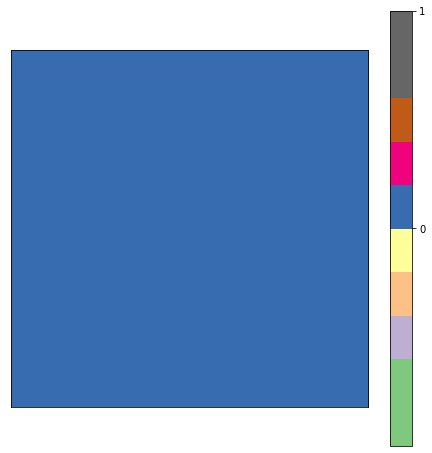

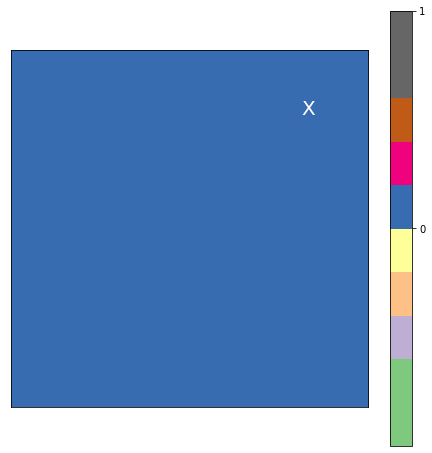

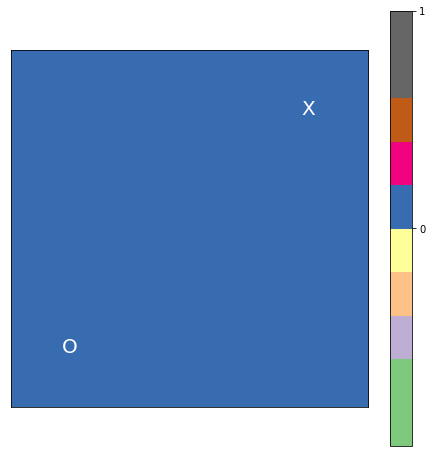

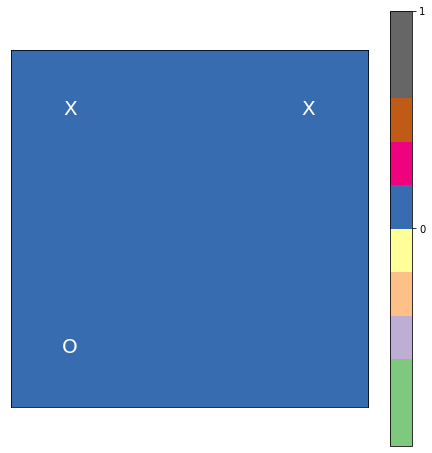

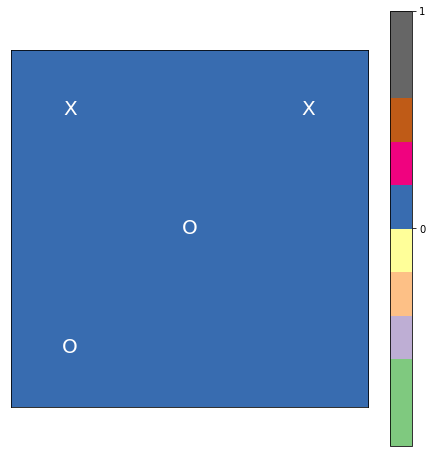

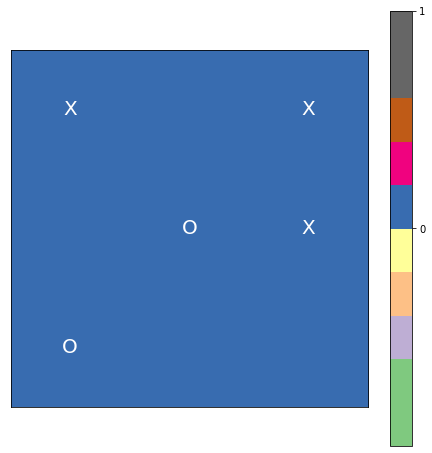

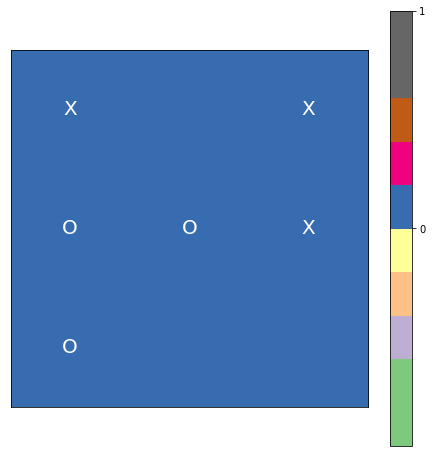

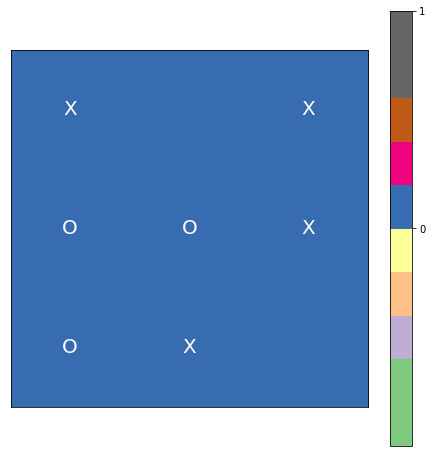

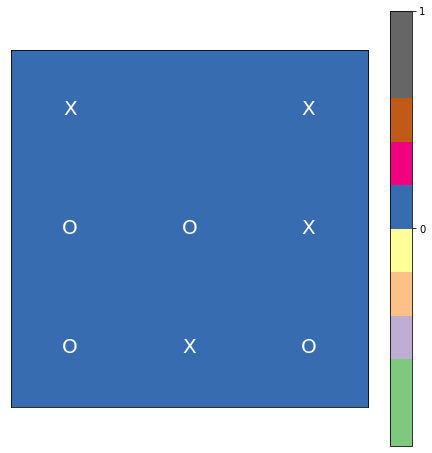

Крестики выиграли!


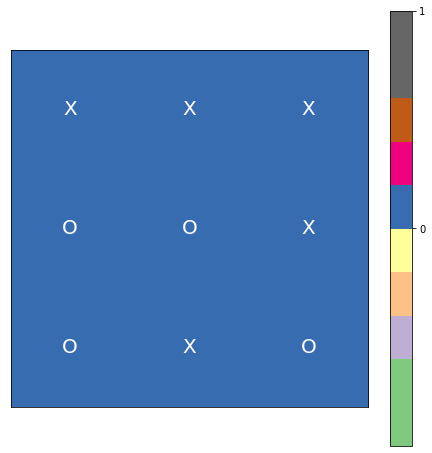

In [ ]:

# import code from lection
from tictactoe_env import *
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

Реализуем случайного агента.

Рeaализуем игру агентов для расёта винрейтов. Кажется, что именно доля побед за большое число игр является репрезентативной метрикой эффективности агента.

Измерение качества будет производиться только для explotation.

In [ ]:
# for validation in games against
class agentRandom():
    name = 'random agent'
    def explotation_action(self, state, actions=None, env=None):
        return env.getEmptySpaces()[np.random.randint(np.sum(np.array(list(state)) == '1') if not actions else actions)]

def cacucate_winrates(env, crosses_agent, zeros_agent, eval_episodes=10000, print_res=False, show_progress = False):
    crosses_wins = 0
    zeros_wins = 0

    if show_progress: 
      for episode in tqdm(range(eval_episodes)):
        gameOver = False
        env.reset()
        while not gameOver:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                action = crosses_agent.explotation_action(s, len(actions), env=env)
            else:
                # invert state for zeros move
                action = zeros_agent.explotation_action(''.join([str(2 - int(n)) for n in s]), len(actions), env=env)
            _, r, gameOver, _ = env.step(action)
          
        if r == 1:
            crosses_wins += 1
        elif r == -1:
            zeros_wins += 1
    else:
      for episode in range(eval_episodes): #tqdm(range(eval_episodes)):
        gameOver = False
        env.reset()
        while not gameOver:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                action = crosses_agent.explotation_action(s, len(actions), env=env)
            else:
                # invert state for zeros move
                action = zeros_agent.explotation_action(''.join([str(2 - int(n)) for n in s]), len(actions),  env=env)
            _, r, gameOver, _ = env.step(action)
          
        if r == 1:
            crosses_wins += 1
        elif r == -1:
            zeros_wins += 1  
        
    crosses_winrate = crosses_wins / eval_episodes
    zeros_winrate = zeros_wins / eval_episodes

    if print_res:
      print('\n')
      print(f'{crosses_agent.name} for crosses winrate {crosses_winrate} \n')
      print(f'{zeros_agent.name} for zeros winrate {zeros_winrate} \n')
      print(f'drawrate {1 - crosses_winrate - zeros_winrate } \n')
    return crosses_winrate, zeros_winrate


In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                    agentRandom(), 
                                                    agentRandom(),
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:07<00:00, 1255.19it/s]



random agent for crosses winrate 0.5801 

random agent for zeros winrate 0.2905 

drawrate 0.12940000000000007 



### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Для агента конкурентная среда (как минимум против сслучайного агента) выглядит стохастической, при этом вариативность огромна, поэтому сделаем предположение что нужно много exploration.

In [ ]:
class agent_QL:

    def __init__(self, alpha=0.3, gamma=1, name = 'QL_agent'):
        self.Qvalues = {}
        self.alpha = alpha
        self.gamma = gamma
        self.name = name
             
    def Vs(self, state):
        return np.max(self.Qs(state))
    
    def Qs(self, state, n_actions=None):
        if state not in self.Qvalues:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            self.Qvalues[state] = np.ones(n_actions) * 0.01
        return self.Qvalues[state]

    def update(self, state, n_action, reward, next_state):
        Q = self.Qs(state)[n_action]
        V = self.Vs(next_state) if next_state else 0
            
        self.Qvalues[state][n_action] = Q + self.alpha * (reward + self.gamma * V - Q)

    def get_action(self, state, epsilon, n_actions=None):
        if np.random.random() > epsilon:
            return self.explotation_action_(state, n_actions)
        else:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            return np.random.randint(n_actions)

    def explotation_action_(self, state, n_actions=None, env=None):
        return np.argmax(self.Qs(state, n_actions))

    def explotation_action(self, state, n_actions=None, env=None):
        return env.getEmptySpaces()[np.argmax(self.Qs(state, n_actions))]

In [ ]:
def visualise_train_results(crosses_winrates, zeros_winrates, agent_to_train, agent_opponent):
    plt.plot([x[0] for x in crosses_winrates], [x[1] for x in crosses_winrates], label='x')
    plt.plot([x[0] for x in crosses_winrates], [x[1] for x in zeros_winrates], label='o')
    
    plt.grid()
    plt.xlabel("episod")
    plt.ylabel("winrate")

    plt.title(f"{agent_to_train.name } for x against {agent_opponent.name} for 1000 games")
    plt.legend()


def train_QL(env, 
             agent_to_train, agent_opponent_for_validation,
             epsilon_start=0.5, epsilon_min= 0.1 , epsilon_decay=0.999,
             train_episodes=100000, eval_episodes = 1000, eval_period = 10000):
    crosses_winrates = []
    zeros_winrates = []
    epsilon = epsilon_start

    for i in tqdm(range(train_episodes)):
        
        # change epsilon in geometric progression
        epsilon = max(epsilon*epsilon_decay, epsilon_min)

        # eval 
        if i % eval_period == 0:

            crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_to_train, agent_opponent_for_validation, eval_episodes= eval_episodes)
            crosses_winrates.append((i, crosses_winrate))

            crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_opponent_for_validation, agent_to_train, eval_episodes=1000)
            zeros_winrates.append((i, zeros_winrate))

        done = False
        env.reset()

        prev_state, prev_actions = env.getHash(), env.getEmptySpaces()
        prev_action = agent_to_train.get_action(prev_state, epsilon, len(prev_actions))
        observation, reward, done, info = env.step(prev_actions[prev_action])
        cur_state, cur_actions = observation[0], observation[1]
        curTurn = env.curTurn
        cur_state = ''.join([str(2 - int(n)) for n in cur_state])
        while not done:
            cur_action = agent_to_train.get_action(cur_state, epsilon, len(cur_actions))
            observation, reward, done, info = env.step(cur_actions[cur_action])
            if done: 
                agent_to_train.update(prev_state, prev_action, -reward * curTurn, None)
                agent_to_train.update(cur_state, cur_action, reward * curTurn, None)
                break

            next_state = observation[0]
            curTurn = env.curTurn
            if curTurn == -1:
                next_state = ''.join([str(2 - int(n)) for n in next_state])
                
            agent_to_train.update(prev_state, prev_action, reward, next_state)
            prev_state, prev_actions = cur_state, cur_actions
            cur_state, cur_actions = next_state, observation[1]
            prev_action = cur_action

    visualise_train_results(crosses_winrates, zeros_winrates, agent_to_train, agent_opponent_for_validation)



Обучим табличного Q learning агента агента на 100 000 эпизодах в процессе обучения будем валидировать агента на 1000 играх за обе стороны каждые 10 000 обучающих игр.

100%|██████████| 100000/100000 [02:28<00:00, 674.84it/s]


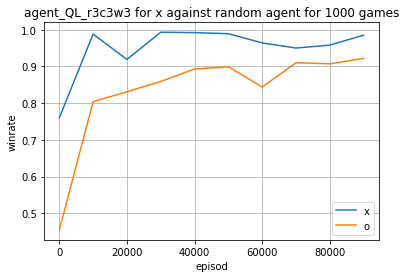

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_QL_r3c3w3 = agent_QL(alpha = 0.1, gamma = 1, name = 'agent_QL_r3c3w3')

train_QL(board_r3c3w3, 
        agent_QL_r3c3w3, agentRandom(),
        epsilon_start=0.7, epsilon_min= 0.05 , epsilon_decay=0.999,
        train_episodes=100000, eval_period = 10000, eval_episodes = 1000)

Играем табличным Q learning против случайного агента за крестики и нолики 10к игр.

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                   agent_QL_r3c3w3, 
                                                   agentRandom(),
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:08<00:00, 1140.18it/s]



agent_QL_r3c3w3 for crosses winrate 0.9875 

random agent for zeros winrate 0.0 

drawrate 0.012499999999999956 



In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                   agentRandom(),
                                                   agent_QL_r3c3w3, 
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:08<00:00, 1133.03it/s]



random agent for crosses winrate 0.0 

agent_QL_r3c3w3 for zeros winrate 0.906 

drawrate 0.09399999999999997 



## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.


### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [ ]:
# used code from 6 lection
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class Network(nn.Module):
    def __init__(self, n_cols, n_rows):
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.conv_out_size = 6
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(1, self.conv_out_size, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Linear(self.conv_out_size * n_cols * n_rows, n_cols * n_rows)

    def forward(self, state):
        x = F.relu(self.conv(state.view(-1, 1, self.n_cols, self.n_rows)))
        x = x.view(-1, self.conv_out_size * self.n_cols * self.n_rows)
        x = self.l2(x)
        return x

In [ ]:
class CossZerosDQN():
    def __init__(self, env):
        self.name = 'CossZerosDQN'
        self.env = env
        self.model = Network(self.env.n_cols, self.env.n_rows)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001) #00.1
        self.steps_done = 0
        self.episode_durations = []

        self.mean_rewards = []
        self.winrates = []
        
        self.gamma = 0.9
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.01, 200
        self.num_step = 0

        
    def action_against_random_agent(self, action):
          (next_state, empty_spaces, cur_turn), reward, done, info = self.env.step(action)
          if done:
              return (next_state, empty_spaces, cur_turn), reward, done, info
          return self.env.step(empty_spaces[np.random.randint(len(empty_spaces))])

    def explotation_action_(self, state, emptySpaces):
        state = state.flatten()
        sorted_actions = self.model(state).data.argsort().numpy().reshape(-1,1)
        for actions in reversed(sorted_actions):
            if actions not in emptySpaces:
                continue
            return self.env.action_from_int(actions)

    def explotation_action(self, state, emptySpaces, env=None):
        with torch.no_grad():
          state = env.board.flatten()
          state_tensor = torch.tensor([state], dtype=torch.float32)

          emptySpaces = env.emptySpaces
          if emptySpaces is None:
            emptySpaces = [[i, j] for i in range(env.n_rows) for j in range(env.n_cols)]
          if len(emptySpaces) == 0:
                  return -1
          emptySpaces = [env.n_cols * i[0] + i[1] for i in emptySpaces]

          state = state_tensor.flatten()
          sorted_actions = self.model(state).data.argsort().numpy().reshape(-1,1)

          for actions in reversed(sorted_actions):
              if actions not in emptySpaces:
                  continue
              return env.action_from_int(actions)


    def get_action(self, state):
        emptySpaces = self.env.emptySpaces
        if emptySpaces is None:
            emptySpaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        if len(emptySpaces) == 0:
                return -1
        emptySpaces = [self.env.n_cols * i[0] + i[1] for i in emptySpaces]
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if np.random.rand() > eps_threshold:
            action = self.explotation_action_(state, emptySpaces)
            action = action[0] * self.env.n_rows + action[1]
        else:
            action = np.random.choice(emptySpaces)
        return torch.tensor([[action]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state, num_step = self.env.board.flatten(), 0
        empty_spaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        while True:

            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.explotation_action_(state_tensor, empty_spaces)
                else:
                    action = self.get_action(state_tensor)
            action_tuple = self.env.action_from_int(action.numpy()[0][0])
            _, reward, done, _ = self.action_against_random_agent(action_tuple)

            next_state = self.env.board.flatten()
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state = next_state
            num_step += 1

            if done:
                self.episode_durations.append(num_step)
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def play_against_random_agent(self):
        self.model.eval()
        
        self.env.reset()
        state, num_step = self.env.board.flatten(), 0
        emptySpaces = [[i, j] for i in range(self.env.n_rows) for j in range(self.env.n_cols)]
        emptySpaces = [self.env.n_cols * i[0] + i[1] for i in emptySpaces]
        while True:

            state_tensor = torch.tensor([state], dtype=torch.float32)
    
            action_tuple = self.explotation_action_(state_tensor, emptySpaces)
        
            _, reward, done, _ = self.action_against_random_agent(action_tuple)
            next_state = self.env.board.flatten()
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            state = next_state
            num_step += 1
            emptySpaces = self.env.emptySpaces
            emptySpaces = [self.env.n_cols * i[0] + i[1] for i in emptySpaces]
            if done:
                break
        return reward, done

    def validate_against_random_agent_with_winrate(self, num_episodes=1000):
        wins = 0
        for i in range(num_episodes):
            reward, done = self.play_against_random_agent()
            if done:
              if reward == 1:
                wins += 1
        self.winrates.append(wins/num_episodes)

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
DQN_r3c3w3 = CossZerosDQN(board_r3c3w3)

for episode in tqdm(range(700)):
    DQN_r3c3w3.run_episode(episode)
    # будем валидировать на 1000 эпизодах со случайным агентом
    DQN_r3c3w3.validate_against_random_agent_with_winrate(1000)

100%|██████████| 700/700 [23:13<00:00,  1.99s/it]


Text(0.5, 1.0, 'DQN against random agent mean for 1000 games')

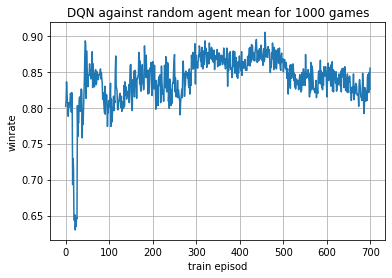

In [ ]:
plt.plot(DQN_r3c3w3.winrates)

plt.grid()
plt.xlabel("train episod")
plt.ylabel("winrate")

plt.title(f"DQN against random agent mean for 1000 games")

Играем DQN с нейронной сетью против случайного агента за крестики и нолики 10к игр.

In [ ]:
%%time
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                   DQN_r3c3w3,
                                                   agentRandom(), 
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:21<00:00, 455.46it/s]



CossZerosDQN for crosses winrate 0.8286 

random agent for zeros winrate 0.1035 

drawrate 0.0679 

CPU times: user 20.6 s, sys: 373 ms, total: 21 s
Wall time: 22 s


In [ ]:
%%time
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                   agentRandom() , 
                                                   DQN_r3c3w3,
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:20<00:00, 476.82it/s]



random agent for crosses winrate 0.5807 

CossZerosDQN for zeros winrate 0.2677 

drawrate 0.1516 

CPU times: user 20.1 s, sys: 362 ms, total: 20.4 s
Wall time: 21 s


Играем DQN с нейронной сетью против табличным Q learning за обе стороны 10к игр.

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                   DQN_r3c3w3,
                                                   agent_QL_r3c3w3, 
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:27<00:00, 364.69it/s]



CossZerosDQN for crosses winrate 0.0 

agent_QL_r3c3w3 for zeros winrate 0.0 

drawrate 1.0 



In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3,
                                                   agent_QL_r3c3w3,
                                                   DQN_r3c3w3,
                                                   print_res=True,
                                                   show_progress=True)

100%|██████████| 10000/10000 [00:16<00:00, 592.07it/s]



agent_QL_r3c3w3 for crosses winrate 1.0 

CossZerosDQN for zeros winrate 0.0 

drawrate 0.0 



### 4. Реализуйте Double DQN и/или Dueling DQN.

## Часть третья: расширим и углубим поиск


Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


### 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [ ]:
class treeNode():

    def __init__(self, env, board, parent_node=None):
        self.env = TicTacToe(env.n_rows, env.n_cols, env.n_win)
        self.env.board = copy.deepcopy(board)
        self.env.isTerminal()
        self.parent_node = parent_node
        self.childs = []
        self.n = 0
        self.cum_rewards = 0
        self.actions = list(self.env.getEmptySpaces())
        
    def rollout(self):
        rollout_env = TicTacToe(self.env.n_rows, self.env.n_cols, self.env.n_win)

        rollout_env.board = copy.deepcopy(self.env.board)
        rollout_env.curTurn = self.env.curTurn
        reward = rollout_env.isTerminal()
        gameOver = rollout_env.gameOver
        random_actions = list(np.random.permutation(rollout_env.getEmptySpaces()))
        while not gameOver:
            action = random_actions.pop()
            _, reward, gameOver, _ = rollout_env.step(action)
        return reward * self.env.curTurn


    def expand_node(self):
        action = self.actions.pop(0)

        next_board = copy.deepcopy(self.env.board)
        next_board[action[0], action[1]] = self.env.curTurn

        child_node = treeNode(self.env, next_board, parent_node=self)
        child_node.env.curTurn = -self.env.curTurn

        self.childs.append(child_node)
        return child_node


    def find_best_children(self, c_parameters=1):
        weights = list(map(lambda node: -node.cum_rewards / node.n + c_parameters * np.sqrt((np.log(self.n) / node.n)),
                           self.childs)) 
        return np.argmax(weights)

    def backprop(self, result):

        self.n += 1.
        self.cum_rewards += result

        if self.parent_node:
            self.parent_node.backprop(-result)

### 6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [ ]:
class agent_MCTS(object):
    def __init__(self, env, num_of_tree_searches):
        self.env = env
        self.num_of_tree_searches = num_of_tree_searches
        self.name = 'MCTSAgent'
        
    def explotation_action(self, s, n_actions, env = None):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols)) - 1
        
        root_node = treeNode(self.env, board)
        for _ in range(self.num_of_tree_searches):            
            v = root_node
            while not v.env.gameOver:
                if len(v.actions) > 0:
                    v = v.expand_node()
                else:
                    v = v.childs[v.find_best_children()]
            reward = v.rollout()
            v.backprop(reward)
        return env.getEmptySpaces()[root_node.find_best_children(c_parameters=0)]

agent MCTS против случайного за обе стороны на доске 3Х3

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=100)
agent_random = agentRandom() 
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_MCTS_r3c3w3, agent_random, print_res=True, eval_episodes=100, show_progress=False )



MCTSAgent for crosses winrate 0.97 

random agent for zeros winrate 0.0 

drawrate 0.030000000000000027 



In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=100)
agent_random = agentRandom() 
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_random, agent_MCTS_r3c3w3, print_res=True, eval_episodes=100, show_progress=True )

100%|██████████| 100/100 [00:21<00:00,  4.71it/s]



random agent for crosses winrate 0.3 

MCTSAgent for zeros winrate 0.59 

drawrate 0.10999999999999999 



Табличный Qlearning против MCTS на доске 3Х3.

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=100) 
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_MCTS_r3c3w3, agent_QL_r3c3w3, print_res=True, eval_episodes=100, show_progress=True )

board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=100)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_QL_r3c3w3, agent_MCTS_r3c3w3,  print_res=True, eval_episodes=100, show_progress=True )


  1%|          | 1/100 [00:00<00:16,  6.03it/s]



MCTSAgent for crosses winrate 0.0 

agent_QL_r3c3w3 for zeros winrate 0.01 

drawrate 0.99 



100%|██████████| 100/100 [00:20<00:00,  4.96it/s]



agent_QL_r3c3w3 for crosses winrate 1.0 

MCTSAgent for zeros winrate 0.0 

drawrate 0.0 



Потрясающе! MCTSAgent с сотней симуляций не может выиграть у табличного QLearnng.

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=500)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_MCTS_r3c3w3, agent_QL_r3c3w3, print_res=True, eval_episodes=100, show_progress=True )

agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=500)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_QL_r3c3w3, agent_MCTS_r3c3w3,  print_res=True, eval_episodes=100, show_progress=True )


  0%|          | 0/100 [00:00<?, ?it/s]



MCTSAgent for crosses winrate 0.0 

agent_QL_r3c3w3 for zeros winrate 0.0 

drawrate 1.0 



100%|██████████| 100/100 [01:16<00:00,  1.30it/s]



agent_QL_r3c3w3 for crosses winrate 1.0 

MCTSAgent for zeros winrate 0.0 

drawrate 0.0 



увеличение числа симуляций не помогло. MCTS Agent отлично сводит игру в ничью за крестики, но не может нолики.

DQN с нейронной сетью против MCTS на доске 3Х3.

In [ ]:
board_r3c3w3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=500)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, agent_MCTS_r3c3w3, DQN_r3c3w3, print_res=True, eval_episodes=100, show_progress=True )

agent_MCTS_r3c3w3 = agent_MCTS(board_r3c3w3, num_of_tree_searches=500)
crosses_winrate, zeros_winrate = cacucate_winrates(board_r3c3w3, DQN_r3c3w3, agent_MCTS_r3c3w3,  print_res=True, eval_episodes=100, show_progress=True )


  0%|          | 0/100 [00:00<?, ?it/s]



MCTSAgent for crosses winrate 0.99 

CossZerosDQN for zeros winrate 0.0 

drawrate 0.010000000000000009 



100%|██████████| 100/100 [01:20<00:00,  1.25it/s]



CossZerosDQN for crosses winrate 0.57 

MCTSAgent for zeros winrate 0.29 

drawrate 0.14000000000000007 



MCTS не может выиграть у табличного QL но выигрывает у DQN.

agent MCTS против случайного за чёрных на доске 4Х4

In [ ]:
board_r4c4w4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
agent_MCTS_r4c4w4 = agent_MCTS(board_r4c4w4, num_of_tree_searches=100)
agent_random = agentRandom() 
crosses_winrate, zeros_winrate = cacucate_winrates(board_r4c4w4, agent_MCTS_r4c4w4, agent_random, print_res=True, eval_episodes=100, show_progress=True )

100%|██████████| 100/100 [01:17<00:00,  1.28it/s]



MCTSAgent for crosses winrate 0.9 

random agent for zeros winrate 0.04 

drawrate 0.05999999999999998 



agent MCTS против случайного за чёрных на доске 5Х5

In [ ]:
board_r5c5w5 = TicTacToe(n_rows=5, n_cols=5, n_win=5)
agent_MCTS_r5c5w5 = agent_MCTS(board_r5c5w5, num_of_tree_searches=100)
agent_random = agentRandom() 
crosses_winrate, zeros_winrate = cacucate_winrates(board_r5c5w5, agent_MCTS_r5c5w5, agent_random, print_res=True, eval_episodes=100, show_progress=True )

100%|██████████| 100/100 [02:34<00:00,  1.54s/it]



MCTSAgent for crosses winrate 0.87 

random agent for zeros winrate 0.0 

drawrate 0.13 

